In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
random_seed = 1337

In [2]:
#get and prepare training data
def get_training_data(dataset_path:str, test_split_ratio:float=0.1,verbose=False):
    data = pd.read_json(dataset_path)
    data["label_train"] = data["label"] - 1
    data["display_text"] = [d[1]['text'][d[1]['displayTextRangeStart']: d[1]['getDisplayTextRangeEnd']] for d in data[["text","displayTextRangeStart", "getDisplayTextRangeEnd"]].iterrows()]
    if verbose : print("max text length", len(data.iloc[np.argmax(data['text'].to_numpy())]['text']))
    max_display_text_length = len(data.iloc[np.argmax(data['display_text'].to_numpy())]['display_text'])
    if verbose : print("max display text length", max_display_text_length)
    X = data.display_text.to_list()
    y = data.label_train.to_list()
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_ratio, random_state=random_seed, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_split_ratio * len(X) / len(X_train), random_state=random_seed, shuffle=True)
    return X_train, y_train, X_val, y_val, X_test, y_test
    

In [3]:
def compute_metrics(pred, labels):
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=100, epochs=3, model=None, model_name = 'distilbert-base-uncased'):
    
    # correct validation set length if it is too long
    ratio = 4
    if len(y_train) / ratio > len(y_val):
        X_val = X_val[0:math.ceil(len(X_val) / ratio)]
        y_val = y_val[0:math.ceil(len(y_val) / ratio)]
    
#     if len(y_train) / ratio > len(y_test):
#         X_test = X_test[0:math.ceil(len(X_test) / ratio)]
#         y_test = y_test[0:math.ceil(len(y_test) / ratio)]
    
    # BEGIN disable logging 
    import logging
    def set_global_logging_level(level=logging.ERROR, prefices=[""]):
        import re
        prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
        for name in logging.root.manager.loggerDict:
            if re.match(prefix_re, name):
                logging.getLogger(name).setLevel(level)
    set_global_logging_level(logging.CRITICAL) # disable INFO and DEBUG logging everywhere
    
    import warnings
    warnings.filterwarnings("ignore")
    # END disable logging
    
    # BEGIN Set determinism !! must be inside function in every loop to work

    from os import environ
    environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # !! important !! import torch after setting cublas deterministic or it will not work !!
    import torch
    from transformers import TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification
    import transformers
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    import random
    random.seed(random_seed)
    
    # END Set determinism
    
     # Create torch dataset
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels=None):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            if self.labels: item["labels"] = torch.tensor(self.labels[idx])
            return item
        def __len__(self):
            return len(self.encodings["input_ids"])
    
    #disable logging
    #transformers.logging.set_verbosity(transformers.logging.CRITICAL)
    
    # create tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(model_name) 
    
    # create datasets
    train_dataset = Dataset(tokenizer(X_train, truncation=True, padding=True, max_length=512), y_train)
    val_dataset = Dataset(tokenizer(X_val, truncation=True, padding=True, max_length=512), y_val)
    test_dataset = Dataset(tokenizer(X_test, padding=True, truncation=True, max_length=512), y_test)
    
    #create model

    if model is None:
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=4)


    #training settings
    args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",
        eval_steps=1,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        seed=random_seed,
        load_best_model_at_end=False
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: compute_metrics(p[0], p[1])
    )
    # disable print log
    from transformers.trainer_callback import PrinterCallback
    trainer.remove_callback(PrinterCallback)

    # Train
    trainer.train()

    # Test
    metrics = trainer.evaluate(test_dataset, metric_key_prefix="")

#     raw_pred, _, _ = trainer.predict(test_dataset)
#     m = compute_metrics(raw_pred, y_test)
    return metrics, trainer, trainer.model

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = get_training_data('data/dataset_1.json', test_split_ratio=0.2)
metrics1, trainer1, model1 = train_model(X_train, y_train, X_val, y_val, X_test, y_test)
metrics2, trainer2, model2 = train_model(X_train, y_train, X_val, y_val, X_test, y_test)
metrics1, metrics2

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.435033,0.826820,0.797222,0.826820,0.780600
2,No log,0.345293,0.884291,0.894065,0.884291,0.866917
3,No log,0.329996,0.885824,0.882407,0.885824,0.873830


***** Running Evaluation *****
  Num examples = 1305
  Batch size = 100
***** Running Evaluation *****
  Num examples = 1305
  Batch size = 100
***** Running Evaluation *****
  Num examples = 1305
  Batch size = 100


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 1305
  Batch size = 100


({'_loss': 0.34015172719955444,
  '_accuracy': 0.871264367816092,
  '_precision': 0.8601053715194783,
  '_recall': 0.871264367816092,
  '_f1': 0.8568178278784206,
  '_runtime': 1.0316,
  '_samples_per_second': 1264.976,
  '_steps_per_second': 13.571,
  'epoch': 3.0},
 {'_loss': 0.34015172719955444,
  '_accuracy': 0.871264367816092,
  '_precision': 0.8601053715194783,
  '_recall': 0.871264367816092,
  '_f1': 0.8568178278784206,
  '_runtime': 0.9664,
  '_samples_per_second': 1350.36,
  '_steps_per_second': 14.487,
  'epoch': 3.0})

In [5]:
len(X_val),len(X_test)

(1305, 1305)

In [15]:
def sbert_tokenize(sentences, verbose=False, bert_model_name='all-mpnet-base-v2'):
    from sentence_transformers import SentenceTransformer, util
    import torch
    model = SentenceTransformer(bert_model_name)
    model.max_seq_length = np.argmax(sentences)
    
    embedding_list = model.encode(sentences, show_progress_bar=verbose)
    return embedding_list

In [17]:
def get_sbert_centroid_args(sentences, num_labels:int, bert_model_name='all-mpnet-base-v2', verbose=False):
    l = len(sentences)
    if l <= 0: return []
    
    # if sample size is smaller than the list there is nothing to sample  then return all indices
    if l < num_labels: return list(range(0, l))
    
    from sentence_transformers import SentenceTransformer, util
    import torch
    model = SentenceTransformer(bert_model_name)
    model.max_seq_length = np.argmax(sentences)
    
    embedding_list = model.encode(sentences, show_progress_bar=verbose)
    from sklearn.cluster import KMeans
    
    clustering_model = KMeans(n_clusters=num_labels, random_state=1337) 
    clustering_model.fit(embedding_list)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(sentence_id)

    centroids = []
    for i in range(len(clustering_model.cluster_centers_)):
        center = clustering_model.cluster_centers_[i]
        # get centroid arg for cluster by min euclidian distance from cluster center
        centroid_arg = clustered_sentences[i][np.argmin([np.linalg.norm(embedding_list[cluster_item_arg]-center) for cluster_item_arg in clustered_sentences[i]])]
        centroids.append(centroid_arg)
    return centroids

In [19]:
centroid_args = get_sbert_centroid_args(sentences=X_train, num_labels=5)
centroid_args.sort()
centroid_args

[359, 400, 869, 3092, 3770]

In [9]:
def get_random_sampling_args(embedding_list, num_labels:int, verbose=False):
    l = len(embedding_list)
    if l <= 0: return []
    # if sample size is smaller than the list there is nothing to sample then return all indices
    if l < num_labels: return list(range(0, l))
    import random
    random.seed(1337) 
    return random.sample(range(0, l), num_labels)

In [10]:
random_args = get_random_sampling_args(embedding_list=X_train, num_labels=5)
random_args.sort()
random_args

[1498, 2184, 2530, 2907, 3790]

In [11]:
def apply_active_learning(algorithm, source, source_y, batch_size=200, epochs=3, continuous_mode=False):
    res = []
    source = list(source)
    source_y = list(source_y)
    i = 0
    samples = []
    samples_y = []
    model = None
    while len(source) > 0:
        if continuous_mode:
            samples = []
            samples_y = []
        
        pick_args = algorithm(source, batch_size)
        #sort reverse or pop will end with argument out of range exception
        pick_args.sort(reverse=True)
 
        # transfer samples from embedding list to samples
        for d in pick_args: 
            samples.append(source.pop(d))
            samples_y.append(source_y.pop(d))
            
        metric, trainer, model = train_model(samples, samples_y, X_val, y_val, X_test, y_test, epochs=epochs, model=model if continuous_mode else None)

        if continuous_mode:
            i = i + len(samples)
            metric["trained_samples"] = i
        else:
            i = i + len(samples)
            metric["trained_samples"] = len(samples)
        res.append(metric)
    return pd.DataFrame(res)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def print_plot(res_rand, res_rand_continuous, res_sbert, res_sbert_continuous, title="Experiments"):
    fig, ax =plt.subplots(1,2, figsize=(18,7))
    sns.lineplot(data=res_rand, x = "trained_samples" ,y = "_accuracy",  color='orange', linewidth=1, ax = ax[0])
    sns.lineplot(data=res_rand_continuous, x = "trained_samples" ,y = "_accuracy",  color='orange',linestyle='--', linewidth=1, ax = ax[0])
    sns.lineplot(data=res_sbert, x = "trained_samples" ,y = "_accuracy",  color='blue', linewidth=1, ax = ax[0])
    sns.lineplot(data=res_sbert_continuous, x = "trained_samples" ,y = "_accuracy",  color='blue',linestyle='--', linewidth=1, ax = ax[0])

    sns.lineplot(data=res_rand, x = "trained_samples" ,y = "_f1",  color='orange', linewidth=1, ax = ax[1])
    sns.lineplot(data=res_rand_continuous, x = "trained_samples" ,y = "_f1",  color='orange',linestyle='--', linewidth=1, ax = ax[1])
    sns.lineplot(data=res_sbert, x = "trained_samples" ,y = "_f1",  color='blue', linewidth=1, ax = ax[1])
    sns.lineplot(data=res_sbert_continuous, x = "trained_samples" ,y = "_f1",  color='blue',linestyle='--', linewidth=1, ax = ax[1])
    ax[0].legend(labels=["Random","Random Continuous", "SBERT","SBERT Continuous"], title = "Accuracy " + title)
    ax[1].legend(labels=["Random","Random Continuous", "SBERT","SBERT Continuous"], title = "F1 " + title)
    fig.show()
# libs for time measurement
from timeit import default_timer as timer
from datetime import timedelta

0:53:08.360623


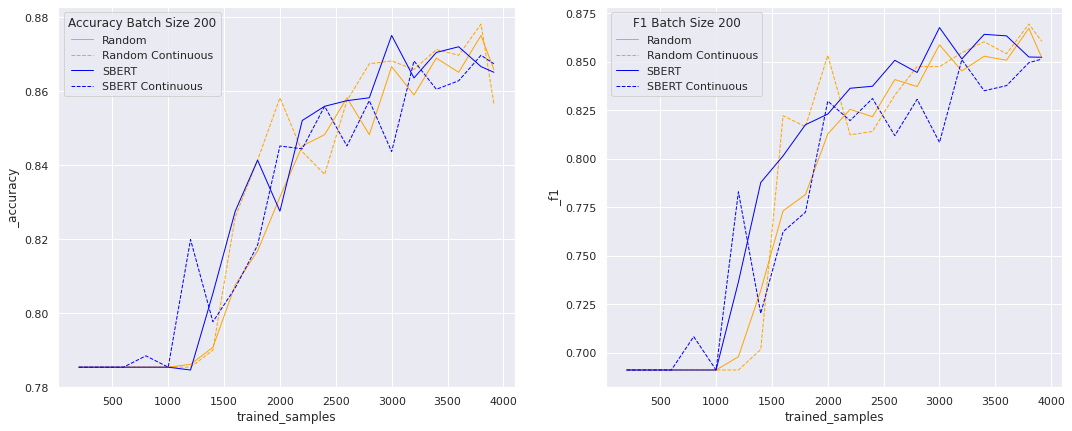

In [13]:
start_200 = timer()
res_rand_200 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=200) 
res_rand_continuous_200 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=200, continuous_mode=True) 
res_sbert_200 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=200)
res_sbert_continuous_200 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=200, continuous_mode=True)
print(timedelta(seconds=timer()-start_200))
print_plot(res_rand_200, res_rand_continuous_200, res_sbert_200, res_sbert_continuous_200, title="Batch Size 200")

0:28:12.520565


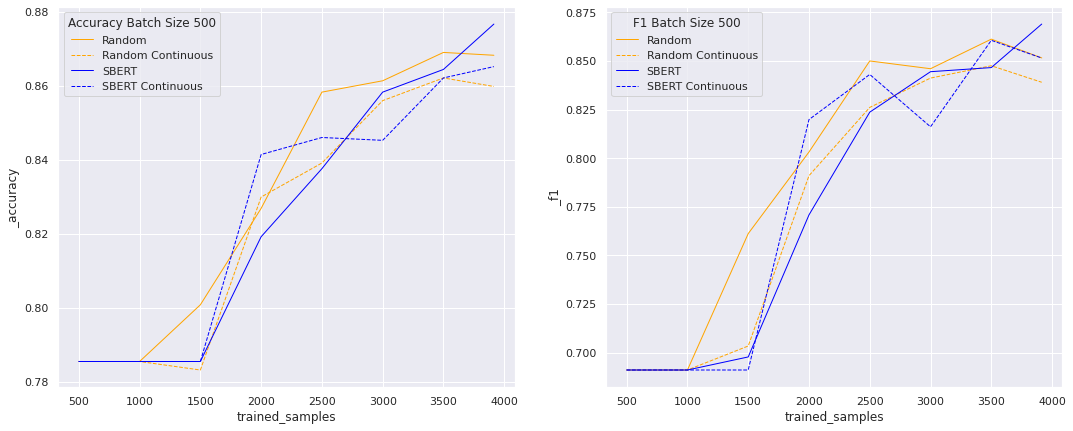

In [14]:
start_500 = timer()
res_rand_500 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=500) 
res_rand_continuous_500 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=500, continuous_mode=True) 
res_sbert_500 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=500)
res_sbert_continuous_500 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=500, continuous_mode=True)
print(timedelta(seconds=timer()-start_500))
print_plot(res_rand_500, res_rand_continuous_500, res_sbert_500, res_sbert_continuous_500, title="Batch Size 500")

In [ ]:
start_1000 = timer()
res_rand_1000 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=1000) 
res_rand_continuous_1000 = apply_active_learning(get_random_sampling_args, X_train, y_train, batch_size=1000, continuous_mode=True) 
res_sbert_1000 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=1000)
res_sbert_continuous_1000 = apply_active_learning(get_sbert_centroid_args, X_train, y_train, batch_size=1000, continuous_mode=True)
print(timedelta(seconds=timer()-start_1000))
print_plot(res_rand_1000, res_rand_continuous_1000, res_sbert_1000, res_sbert_continuous_1000, title="Batch Size 1000")